In [ ]:
/workspace/slice-monorepo/thebeast/combined

In [ ]:
!pip install -q scikit-learn tensorflow transformers matplotlib

Epoch 1/50000 | Data size: 100.5 | Train Loss: 0.00560266 | Val Loss: 0.00230649 | Train Acc: 0.32% | Val Acc: 0.25%
Epoch 2/50000 | Data size: 101.0025 | Train Loss: 0.00212276 | Val Loss: 0.00153161 | Train Acc: -0.09% | Val Acc: 1.19%
Epoch 3/50000 | Data size: 101.5075125 | Train Loss: 0.00153863 | Val Loss: 0.00122420 | Train Acc: 1.90% | Val Acc: 3.05%
Epoch 4/50000 | Data size: 102.01505006250001 | Train Loss: 0.00127509 | Val Loss: 0.00106259 | Train Acc: 3.17% | Val Acc: 3.83%
Epoch 5/50000 | Data size: 102.5251253128125 | Train Loss: 0.00112968 | Val Loss: 0.00093658 | Train Acc: 3.86% | Val Acc: 4.46%
Epoch 6/50000 | Data size: 103.03775093937656 | Train Loss: 0.00098667 | Val Loss: 0.00082781 | Train Acc: 4.70% | Val Acc: 5.31%
Epoch 7/50000 | Data size: 103.55293969407344 | Train Loss: 0.00087665 | Val Loss: 0.00071954 | Train Acc: 5.11% | Val Acc: 7.00%
Epoch 8/50000 | Data size: 104.07070439254382 | Train Loss: 0.00076832 | Val Loss: 0.00062549 | Train Acc: 6.78% | Val A

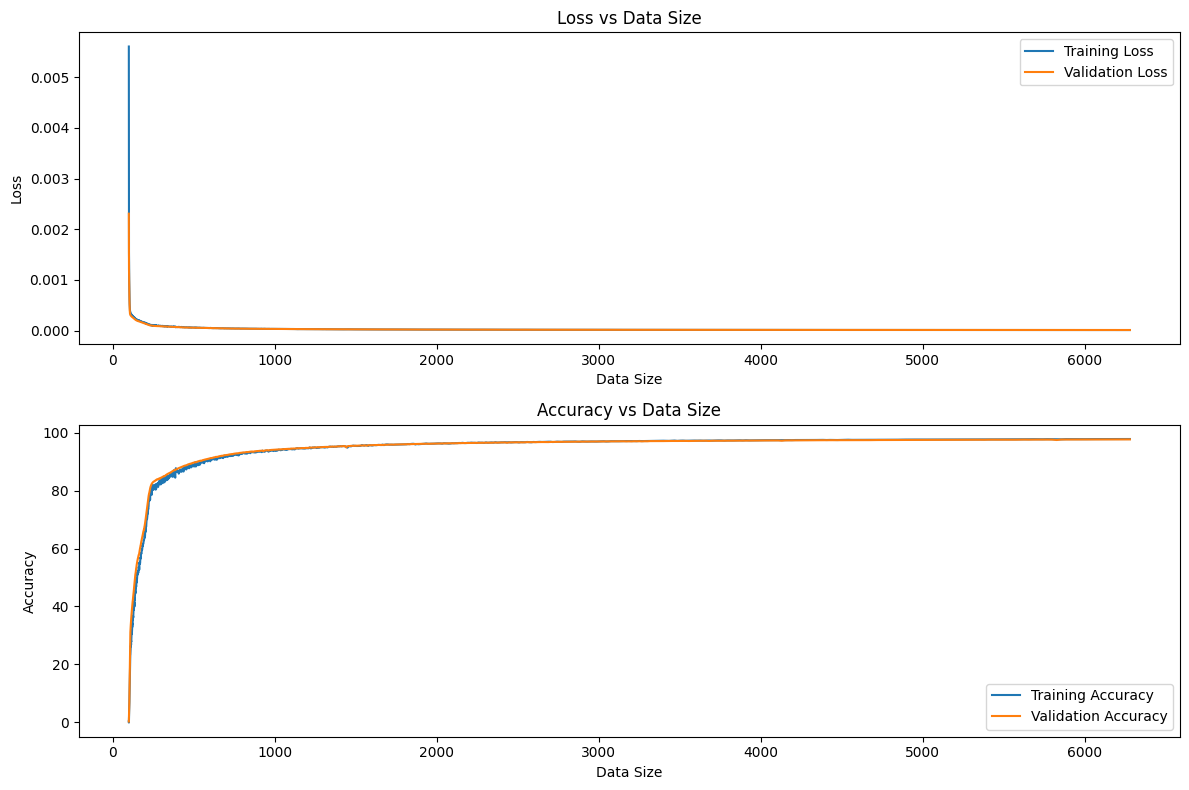

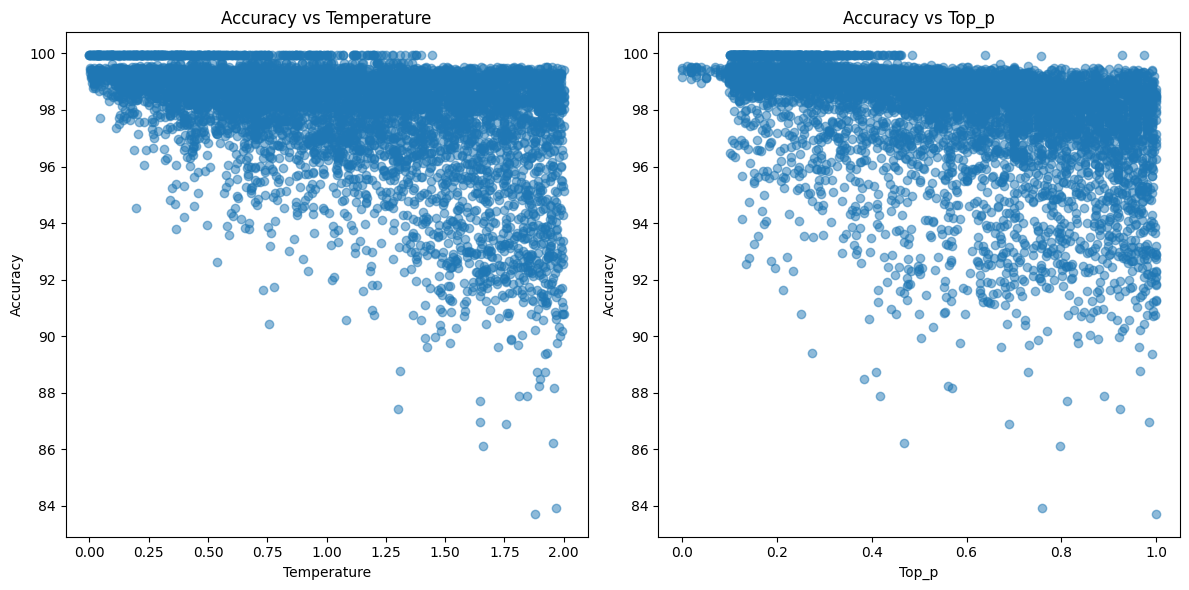

In [1]:
#EMBEDDINGS AUTOENCODER >90% accuracy
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, folder_path):
        self.data = []
        for filename in os.listdir(folder_path):
            if filename.endswith(".json"):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    if isinstance(json_data, dict):  # To handle different structures
                        json_data = [json_data]
                    for item in json_data:
                        embedding = item['embedding']
                        temp = float(item['configuration']['temperature'])
                        top_p = float(item['configuration']['top_p'])
                        self.data.append((embedding, temp, top_p))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding, temp, top_p = self.data[idx]
        return torch.tensor(embedding, dtype=torch.float32), temp, top_p

# Define the Autoencoder model using a pretrained BERT model as the encoder
class BertAutoencoder(nn.Module):
    def __init__(self, bert_model_name, embedding_dim=3072, hidden_dim=768, lstm_units=256, sequence_length=4):
        super(BertAutoencoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_adapter = nn.Linear(embedding_dim, hidden_dim * sequence_length)
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.decoder = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.output_layer = nn.Linear(lstm_units, hidden_dim)

    def forward(self, x):
        x = self.embedding_adapter(x)
        x = x.view(x.size(0), self.sequence_length, -1)  # Reshape to (batch_size, sequence_length, hidden_dim)
        encoder_outputs = self.bert(inputs_embeds=x).last_hidden_state
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.output_layer(decoder_outputs)
        return output

# Calculate accuracy as a similarity measure
def calculate_accuracy(outputs, targets):
    cos = nn.CosineSimilarity(dim=-1)
    accuracy = cos(outputs, targets).mean().item()
    return accuracy * 100  # Convert to percentage

# Progressive data increment method
def progressive_training(model, dataset, initial_size, increment_ratio, max_epochs, device):
    total_size = len(dataset)
    test_size = 0.1
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    metrics = []

    # Separate the test data and ensure it's shuffled
    train_size = int((1 - test_size) * total_size)
    test_size = total_size - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    current_size = initial_size

    for epoch in range(max_epochs):
        if current_size > train_size:
            break

        current_train_indices = torch.randperm(train_size)[:int(current_size)]
        current_train_dataset = torch.utils.data.Subset(train_dataset, current_train_indices)
        train_loader = DataLoader(current_train_dataset, batch_size=32, shuffle=True)

        model.train()
        train_loss, train_accuracy = 0, 0
        for inputs, _, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

        train_accuracy /= len(train_loader)

        model.eval()
        val_loss, val_accuracy = 0, 0
        with torch.no_grad():
            for inputs, _, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))
                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

        val_accuracy /= len(test_loader)

        metrics.append((current_size, train_loss/len(train_loader), val_loss/len(test_loader), train_accuracy, val_accuracy))
        current_size += current_size * increment_ratio

        print(f'Epoch {epoch+1}/{max_epochs} | Data size: {current_size} | Train Loss: {train_loss/len(train_loader):.8f} | Val Loss: {val_loss/len(test_loader):.8f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Plotting function
def plot_metrics(metrics):
    sizes, train_losses, val_losses, train_accuracies, val_accuracies = zip(*metrics)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(sizes, train_losses, label='Training Loss')
    plt.plot(sizes, val_losses, label='Validation Loss')
    plt.xlabel('Data Size')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Data Size')

    plt.subplot(2, 1, 2)
    plt.plot(sizes, train_accuracies, label='Training Accuracy')
    plt.plot(sizes, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Data Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Data Size')

    plt.tight_layout()
    plt.show()

# Plot temp/top_p vs accuracy
def plot_temp_top_p_vs_accuracy(dataset, model, device):
    temps, top_ps, accuracies = [], [], []

    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for inputs, temp, top_p in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            accuracy = calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

            temps.append(temp.item())
            top_ps.append(top_p.item())
            accuracies.append(accuracy)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(temps, accuracies, alpha=0.5)
    plt.xlabel('Temperature')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Temperature')

    plt.subplot(1, 2, 2)
    plt.scatter(top_ps, accuracies, alpha=0.5)
    plt.xlabel('Top_p')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Top_p')

    plt.tight_layout()
    plt.show()

# Main function
def main(folder_path):
    dataset = EmbeddingDataset(folder_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertAutoencoder('bert-base-uncased', lstm_units=256, hidden_dim=768, sequence_length=4).to(device)

    initial_size = 100
    increment_ratio = 0.005
    max_epochs = 50000

    metrics = progressive_training(model, dataset, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

    # Save the model
    torch.save(model.state_dict(), 'bert_autoencoder_model.pth')

    plot_metrics(metrics)
    plot_temp_top_p_vs_accuracy(dataset, model, device)

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)


In [4]:
!pip install -q pip install umap-learn seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


2024-06-13 00:09:56.047681: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 00:09:56.048273: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 00:09:56.052310: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 00:09:56.086322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 00:09:56.901174: W tensorflow/compiler/tf2tensorrt/utils/py_uti

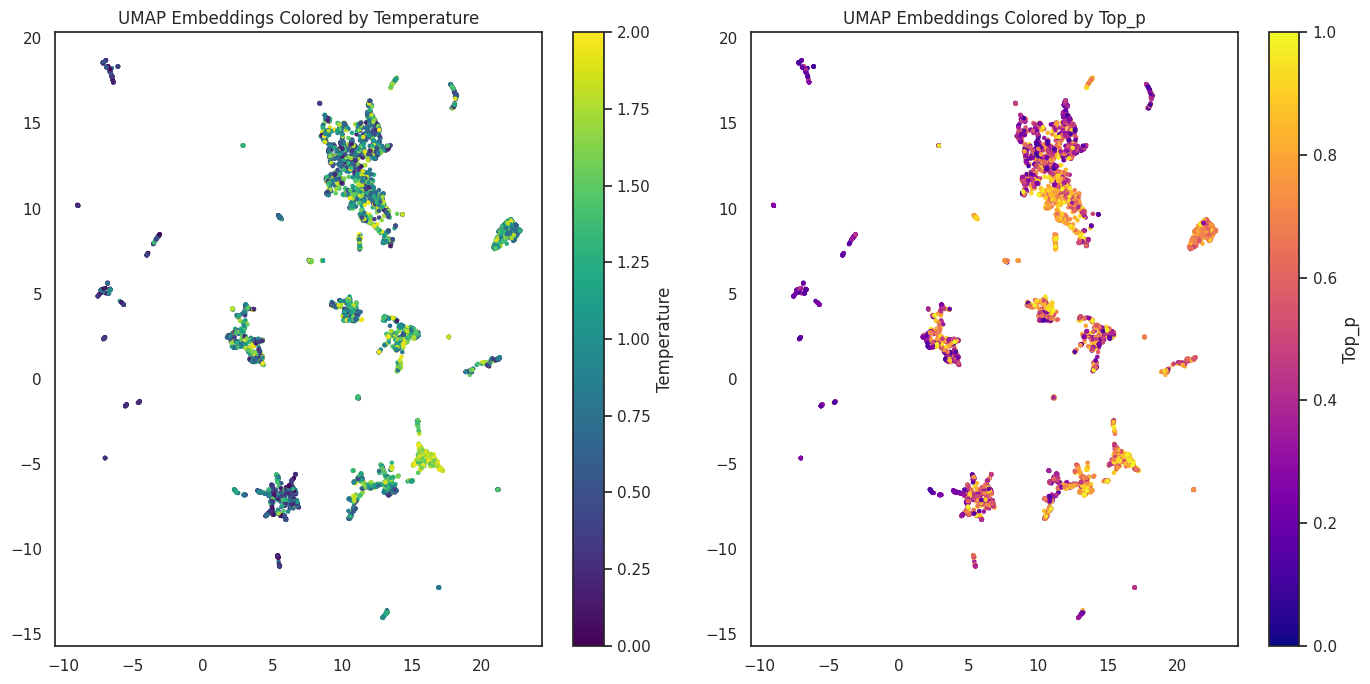

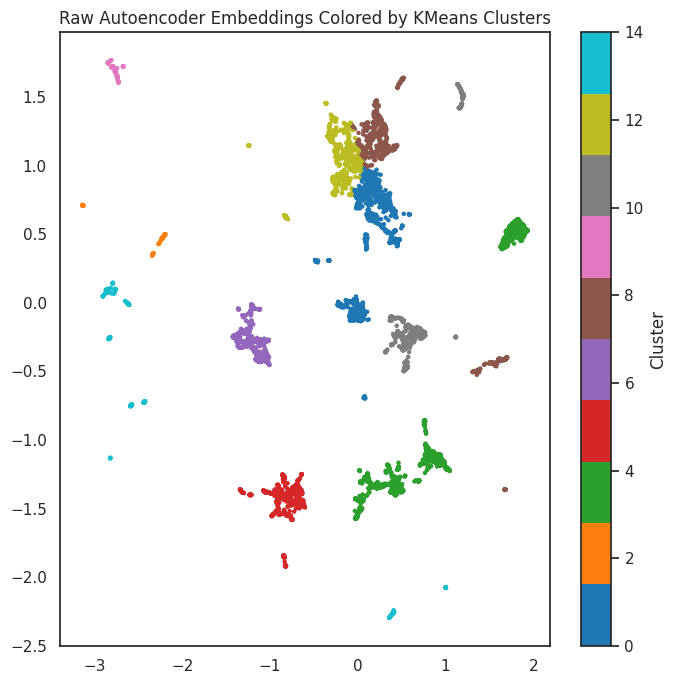

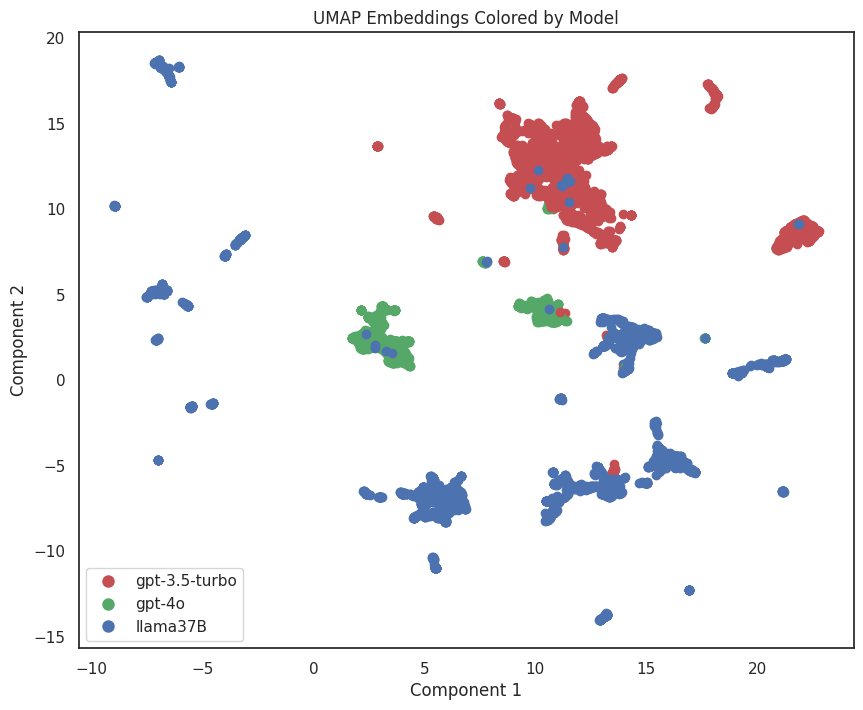

Cluster 0:
Random Sample of Responses: ['As a time traveler visiting Earth in the year 3000, the most surprising change I notice is in the realm of technology, specifically the advent of fully integrated neural interfaces. These interfaces have revolutionized the way humans interact with both the digital and physical worlds, creating a seamless blend of reality and augmented experiences.\n\n### Description of the Change:\nNeural interfaces are advanced devices that connect directly to the human brain, allowing individuals to control technology with their thoughts and experience digital environments as if they were real. These interfaces are embedded at birth and grow with the individual, adapting to their neural patterns and preferences over time. They enable a range of capabilities, including:\n\n1. **Instant Knowledge Acquisition**: Information', 'As a time traveler visiting Earth in the year 3000, I\'m struck by the most surprising change I notice in the area of technology: the wide

In [5]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from transformers import BertModel
import torch.nn as nn
import pandas as pd
import random

sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

class BertAutoencoder(nn.Module):
    def __init__(self, bert_model_name, embedding_dim=3072, hidden_dim=768, lstm_units=256, sequence_length=4):
        super(BertAutoencoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_adapter = nn.Linear(embedding_dim, hidden_dim * sequence_length)
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.decoder = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.output_layer = nn.Linear(lstm_units, hidden_dim)

    def forward(self, x):
        x = self.embedding_adapter(x)
        x = x.view(x.size(0), self.sequence_length, -1)  # Reshape to (batch_size, sequence_length, hidden_dim)
        encoder_outputs = self.bert(inputs_embeds=x).last_hidden_state
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.output_layer(decoder_outputs)
        return output
    
    def encode(self, x):
        x = self.embedding_adapter(x)
        x = x.view(x.size(0), self.sequence_length, -1)  # Reshape to (batch_size, sequence_length, hidden_dim)
        encoder_outputs = self.bert(inputs_embeds=x).last_hidden_state
        return encoder_outputs

def load_model(model_path, device):
    model = BertAutoencoder('bert-base-uncased', lstm_units=256, hidden_dim=768, sequence_length=4).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def process_embedding(model, embedding, device):
    embedding = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        encoded = model.encode(embedding)
    return encoded.squeeze(0).cpu().numpy()

def load_embedding_data(folder_path):
    embeddings = []
    temps = []
    top_ps = []
    configs = []
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                if isinstance(json_data, dict):  # To handle different structures
                    json_data = [json_data]
                for item in json_data:
                    embedding = item['embedding']
                    temp = float(item['configuration']['temperature'])
                    top_p = float(item['configuration']['top_p'])
                    embeddings.append(embedding)
                    temps.append(temp)
                    top_ps.append(top_p)
                    configs.append(item['configuration'])
                    data.append(item)
    return embeddings, temps, top_ps, configs, data

def umap_embeddings(encoded_embeddings, temps, top_ps):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(encoded_embeddings)

    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(scaled_embeddings)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=temps, cmap='viridis', s=5)
    plt.colorbar(label='Temperature')
    plt.title('UMAP Embeddings Colored by Temperature')

    plt.subplot(1, 2, 2)
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=top_ps, cmap='plasma', s=5)
    plt.colorbar(label='Top_p')
    plt.title('UMAP Embeddings Colored by Top_p')

    plt.tight_layout()
    plt.show()
    
    return umap_embeddings

def kmeans_clustering(encoded_embeddings, n_clusters=5):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(encoded_embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_embeddings)

    plt.figure(figsize=(7, 7))
    plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], c=clusters, cmap='tab10', s=5)
    plt.colorbar(label='Cluster')
    plt.title('Raw Autoencoder Embeddings Colored by KMeans Clusters')
    plt.tight_layout()
    plt.show()
    
    return clusters

def visualize_clusters_by_model(embeddings, labels, configs, title):
    model_colors = {
        'gpt-3.5-turbo': 'r',
        'gpt-4o': 'g',
        'llama37B': 'b'
    }
    
    plt.figure(figsize=(10, 8))
    for i, (embedding, config) in enumerate(zip(embeddings, configs)):
        model_name = config.get('model', 'llama37B')
        color = model_colors.get(model_name, 'b')
        plt.scatter(embedding[0], embedding[1], color=color, label=model_name if i == 0 else "")

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=model) 
               for model, color in model_colors.items()]
    plt.legend(handles=handles)
    plt.show()

def load_results(filename):
    with open(filename, 'r') as f:
        results = json.load(f)
    results['embeddings'] = np.array(results['embeddings'])
    results['labels'] = np.array(results['labels'])
    return results

def save_results(results, filename):
    results['embeddings'] = results['embeddings'].tolist()
    results['labels'] = results['labels'].tolist()
    
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)

def remove_clusters(data, labels, configs, clusters_to_remove):
    filtered_data = [item for i, item in enumerate(data) if labels[i] not in clusters_to_remove]
    filtered_embeddings = [embedding for i, embedding in enumerate(results['embeddings']) if labels[i] not in clusters_to_remove]
    filtered_labels = [label for label in labels if label not in clusters_to_remove]
    filtered_configs = [configs[i] for i, label in enumerate(labels) if label not in clusters_to_remove]
    return filtered_data, np.array(filtered_embeddings), filtered_labels, filtered_configs

def recluster_data(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    new_labels = kmeans.fit_predict(embeddings)
    return kmeans, new_labels

def calculate_central_configs(configs, labels, n_clusters):
    config_df = pd.DataFrame(configs)
    config_df = config_df.drop(columns=['batch_size', 'max_tokens', 'max_seq_len'], errors='ignore')
    numeric_columns = config_df.select_dtypes(include=[np.number]).columns
    central_configs = config_df.groupby(labels)[numeric_columns].mean().to_dict(orient='records')
    return central_configs

def visualize_and_analyze(new_labels, embeddings):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for cluster in range(max(new_labels)+1):
        points = reduced_embeddings[new_labels == cluster]
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}')
    plt.legend()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Re-clustered Visualization')
    plt.show()

def display_cluster_details(data, labels):
    for i in range(max(labels)+1):
        cluster_items = [item['response_content'] for j, item in enumerate(data) if labels[j] == i]
        avg_length = np.mean([len(item) for item in cluster_items])
        random_sample = random.sample(cluster_items, min(5, len(cluster_items)))
        print(f'Cluster {i}:')
        print('Random Sample of Responses:', random_sample)
        print('Total Responses:', len(cluster_items))
        print('Average Length of Responses:', avg_length)
        print()

def main(folder_path):
    model_path = 'bert_autoencoder_model.pth'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_model(model_path, device)

    embeddings, temps, top_ps, configs, data = load_embedding_data(folder_path)

    # Process all embeddings to get encoded representations
    encoded_embeddings = []
    for embedding in embeddings:
        encoded = process_embedding(model, embedding, device)
        encoded_embeddings.append(encoded.flatten())  # Flatten to 2D array for UMAP

    encoded_embeddings = np.array(encoded_embeddings)

    # Apply UMAP and visualize
    umap_embeds = umap_embeddings(encoded_embeddings, temps, top_ps)

    # Apply KMeans and visualize
    kmeans_clusters = kmeans_clustering(umap_embeds, n_clusters=15)

    # Visualize clusters by model type using UMAP embeddings
    visualize_clusters_by_model(umap_embeds, kmeans_clusters, configs, 'UMAP Embeddings Colored by Model')
    # Save clustering results
    results = {
        'embeddings': encoded_embeddings,
        'labels': kmeans_clusters,
        'configs': configs
    }
    save_results(results, 'cluster_results.json')

    # Display cluster details
    display_cluster_details(data, kmeans_clusters)

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, folder_path):
        self.data = []
        for filename in os.listdir(folder_path):
            if filename.endswith(".json"):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    if isinstance(json_data, dict):  # To handle different structures
                        json_data = [json_data]
                    for item in json_data:
                        embedding = item['embedding']
                        temp = float(item['configuration']['temperature'])
                        top_p = float(item['configuration']['top_p'])
                        self.data.append((embedding, temp, top_p))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding, temp, top_p = self.data[idx]
        return torch.tensor(embedding, dtype=torch.float32), temp, top_p

# Define the Autoencoder model using a pretrained BERT model as the encoder
class BertAutoencoder(nn.Module):
    def __init__(self, bert_model_name, embedding_dim=3072, hidden_dim=768, lstm_units=256, sequence_length=4):
        super(BertAutoencoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_adapter = nn.Linear(embedding_dim, hidden_dim * sequence_length)
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.decoder = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.output_layer = nn.Linear(lstm_units, hidden_dim)

    def forward(self, x):
        x = self.embedding_adapter(x)
        x = x.view(x.size(0), self.sequence_length, -1)  # Reshape to (batch_size, sequence_length, hidden_dim)
        encoder_outputs = self.bert(inputs_embeds=x).last_hidden_state
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.output_layer(decoder_outputs)
        return output

# Calculate accuracy as a similarity measure
def calculate_accuracy(outputs, targets):
    cos = nn.CosineSimilarity(dim=-1)
    accuracy = cos(outputs, targets).mean().item()
    return accuracy * 100  # Convert to percentage

# Progressive data increment method
def progressive_training(model, dataset, initial_size, increment_ratio, max_epochs, device):
    total_size = len(dataset)
    test_size = 0.1
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    metrics = []

    # Separate the test data and ensure it's shuffled
    train_size = int((1 - test_size) * total_size)
    test_size = total_size - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    current_size = initial_size

    for epoch in range(max_epochs):
        if current_size > train_size:
            break

        current_train_indices = torch.randperm(train_size)[:current_size]
        current_train_dataset = torch.utils.data.Subset(train_dataset, current_train_indices)
        train_loader = DataLoader(current_train_dataset, batch_size=32, shuffle=True)

        model.train()
        train_loss, train_accuracy = 0, 0
        for inputs, _, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

        train_accuracy /= len(train_loader)

        model.eval()
        val_loss, val_accuracy = 0, 0
        with torch.no_grad():
            for inputs, _, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))
                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

        val_accuracy /= len(test_loader)

        metrics.append((current_size, train_loss/len(train_loader), val_loss/len(test_loader), train_accuracy, val_accuracy))
        current_size += int(current_size * increment_ratio)

        print(f'Epoch {epoch+1}/{max_epochs} | Data size: {current_size} | Train Loss: {train_loss/len(train_loader):.8f} | Val Loss: {val_loss/len(test_loader):.8f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Plotting function
def plot_metrics(metrics):
    sizes, train_losses, val_losses, train_accuracies, val_accuracies = zip(*metrics)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(sizes, train_losses, label='Training Loss')
    plt.plot(sizes, val_losses, label='Validation Loss')
    plt.xlabel('Data Size')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Data Size')

    plt.subplot(2, 1, 2)
    plt.plot(sizes, train_accuracies, label='Training Accuracy')
    plt.plot(sizes, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Data Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Data Size')

    plt.tight_layout()
    plt.show()

# Plot temp/top_p vs accuracy
def plot_temp_top_p_vs_accuracy(dataset, model, device):
    temps, top_ps, accuracies = [], [], []

    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for inputs, temp, top_p in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            accuracy = calculate_accuracy(outputs, inputs.view(outputs.size(0), model.sequence_length, -1))

            temps.append(temp.item())
            top_ps.append(top_p.item())
            accuracies.append(accuracy)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(temps, accuracies, alpha=0.5)
    plt.xlabel('Temperature')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Temperature')

    plt.subplot(1, 2, 2)
    plt.scatter(top_ps, accuracies, alpha=0.5)
    plt.xlabel('Top_p')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Top_p')

    plt.tight_layout()
    plt.show()

# Main function
def main(folder_path):
    dataset = EmbeddingDataset(folder_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertAutoencoder('bert-base-uncased', lstm_units=256, hidden_dim=768, sequence_length=4).to(device)

    initial_size = 10
    increment_ratio = 0.1
    max_epochs = 5000

    metrics = progressive_training(model, dataset, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

    # Save the model
    torch.save(model.state_dict(), 'bert_autoencoder_model.pth')

    plot_metrics(metrics)
    plot_temp_top_p_vs_accuracy(dataset, model, device)

if __name__ == "__main__":
    folder_path = '/workspace/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Load data from JSON files in the specified folder
def load_data(folder_path):
    texts = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                if isinstance(data, dict) and 'response_content' in data:
                    texts.append(data['response_content'])
                elif isinstance(data, list):
                    for item in data:
                        if 'response_content' in item:
                            texts.append(item['response_content'])
    return texts

# Preprocess text data using a tokenizer
def preprocess_texts(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings.input_ids, encodings.attention_mask

# Define the Autoencoder model using a pretrained BERT model as the encoder
class BertAutoencoder(nn.Module):
    def __init__(self, bert_model_name, lstm_units=256, max_length=512):
        super(BertAutoencoder, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.encoder = self.bert.encoder
        self.decoder = nn.LSTM(self.bert.config.hidden_size, lstm_units, batch_first=True)
        self.output_layer = nn.Linear(lstm_units, self.bert.config.vocab_size)
        self.max_length = max_length

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encoder_outputs = bert_outputs.last_hidden_state
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.output_layer(decoder_outputs)
        return output

# Progressive data increment method
def progressive_training(model, data, attention_masks, tokenizer, initial_size, increment_ratio, max_epochs, device):
    current_size = initial_size
    total_size = len(data)
    test_size = 0.1
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    metrics = []
    
    # Split data into training and test sets
    train_indices, test_indices = train_test_split(np.arange(total_size), test_size=test_size, shuffle=True)
    
    x_test, mask_test = data[test_indices], attention_masks[test_indices]
    x_train_full, mask_train_full = data[train_indices], attention_masks[train_indices]
    
    test_dataset = TensorDataset(x_test, x_test, mask_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    for epoch in range(max_epochs):
        if current_size > len(train_indices):
            break
            
        current_train_indices = train_indices[:int(current_size)]
        current_data = data[current_train_indices]
        current_masks = attention_masks[current_train_indices]
        
        x_train, y_train, mask_train = current_data, current_data, current_masks
        
        train_dataset = TensorDataset(x_train, y_train, mask_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets, masks in train_loader:
            inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, masks)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(2)
            total += targets.size(0) * targets.size(1)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets, masks in test_loader:
                inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                val_loss += loss.item()
                _, predicted = outputs.max(2)
                total += targets.size(0) * targets.size(1)
                correct += predicted.eq(targets).sum().item()

        val_accuracy = 100. * correct / total
        metrics.append((current_size, train_loss/len(train_loader), val_loss/len(test_loader), train_accuracy, val_accuracy))
        current_size += current_size * increment_ratio

        print(f'Epoch {epoch+1}/{max_epochs} | Data size: {current_size} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(test_loader):.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Plotting function
def plot_metrics(metrics):
    sizes, train_losses, val_losses, train_accuracies, val_accuracies = zip(*metrics)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(sizes, train_losses, label='Training Loss')
    plt.plot(sizes, val_losses, label='Validation Loss')
    plt.xlabel('Data Size')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Data Size')

    plt.subplot(2, 1, 2)
    plt.plot(sizes, train_accuracies, label='Training Accuracy')
    plt.plot(sizes, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Data Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Data Size')

    plt.tight_layout()
    plt.show()

def plot_test_data_and_accuracy(test_data, test_masks, model, tokenizer, device):
    model.eval()
    test_loader = DataLoader(TensorDataset(test_data, test_masks), batch_size=1, shuffle=False)

    original_texts = tokenizer.batch_decode(test_data, skip_special_tokens=True)
    predicted_texts = []

    with torch.no_grad():
        for inputs, masks in test_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs, masks)
            _, predicted = outputs.max(2)
            predicted_texts.extend(tokenizer.batch_decode(predicted.cpu(), skip_special_tokens=True))

    for original, predicted in zip(original_texts, predicted_texts):
        print(f'Original: {original}')
        print(f'Predicted: {predicted}')
        print('---')

# Main function
def main(folder_path):
    texts = load_data(folder_path)
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    input_ids, attention_masks = preprocess_texts(texts, tokenizer)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertAutoencoder('bert-base-uncased', lstm_units=256, max_length=512).to(device)

    initial_size = 100
    increment_ratio = 0.01
    max_epochs = 50000

    metrics = progressive_training(model, input_ids, attention_masks, tokenizer, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

    plot_metrics(metrics)

    x_train, x_test, mask_train, mask_test = train_test_split(input_ids, attention_masks, test_size=0.1)
    plot_test_data_and_accuracy(x_test[:5], mask_test[:5], model, tokenizer, device)  # Display 5 samples

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load data from JSON files in the specified folder
def load_data(folder_path):
    texts = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                if isinstance(data, dict) and 'response_content' in data:
                    texts.append(data['response_content'])
                elif isinstance(data, list):
                    for item in data:
                        if 'response_content' in item:
                            texts.append(item['response_content'])
    return texts

# Tokenize and pad the text data
def preprocess_texts(texts, tokenizer, max_length=512):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded_sequences

class TextTokenizer:
    def __init__(self, oov_token="<OOV>"):
        self.oov_token = oov_token
        self.word_index = {oov_token: 1}
        self.index_word = {1: oov_token}
        self.word_counts = {}
        self.num_words = 2

    def fit_on_texts(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.word_counts:
                    self.word_counts[word] = 1
                else:
                    self.word_counts[word] += 1

        sorted_words = sorted(self.word_counts.items(), key=lambda item: item[1], reverse=True)
        for word, _ in sorted_words:
            self.word_index[word] = self.num_words
            self.index_word[self.num_words] = word
            self.num_words += 1

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, self.word_index[self.oov_token]) for word in text.split()])
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            texts.append(' '.join([self.index_word.get(idx, self.oov_token) for idx in seq]))
        return texts

# Padding function
def pad_sequences(sequences, maxlen, padding='post', truncating='post'):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            if truncating == 'pre':
                seq = seq[-maxlen:]
            elif truncating == 'post':
                seq = seq[:maxlen]
        if padding == 'pre':
            padded_sequences[i, -len(seq):] = seq
        elif padding == 'post':
            padded_sequences[i, :len(seq)] = seq
    return padded_sequences

# Define the Autoencoder model
class TextAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=256, max_length=512):
        super(TextAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.decoder = nn.LSTM(lstm_units, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        self.max_length = max_length

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        repeated_hidden = hidden.repeat(self.max_length, 1, 1).permute(1, 0, 2)
        decoded, _ = self.decoder(repeated_hidden)
        output = self.output_layer(decoded)
        return output

# Progressive data increment method
def progressive_training(model, data, tokenizer, vocab_size, initial_size, increment_ratio, max_epochs, device):
    current_size = initial_size
    total_size = len(data)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    metrics = []

    for epoch in range(max_epochs):
        if current_size > total_size:
            break
        current_data = data[:current_size]
        x_train, x_test, y_train, y_test = train_test_split(current_data, current_data, test_size=0.1)

        x_train = torch.tensor(x_train, dtype=torch.long).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)
        x_test = torch.tensor(x_test, dtype=torch.long).to(device)
        y_test = torch.tensor(y_test, dtype=torch.long).to(device)

        train_dataset = TensorDataset(x_train, y_train)
        test_dataset = TensorDataset(x_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(2)
            total += targets.size(0) * targets.size(1)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
                val_loss += loss.item()
                _, predicted = outputs.max(2)
                total += targets.size(0) * targets.size(1)
                correct += predicted.eq(targets).sum().item()

        val_accuracy = 100. * correct / total
        metrics.append((current_size, train_accuracy, val_accuracy))
        current_size += int(current_size * increment_ratio)

        print(f'Epoch {epoch+1}/{max_epochs} completed with {current_size} samples. Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    return metrics

# Main function
def main(folder_path):
    texts = load_data(folder_path)
    tokenizer = TextTokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = preprocess_texts(texts, tokenizer)
    vocab_size = len(tokenizer.word_index) + 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TextAutoencoder(vocab_size, embedding_dim=128, lstm_units=256, max_length=512).to(device)

    initial_size = 100
    increment_ratio = 0.01
    max_epochs = 5000

    metrics = progressive_training(model, sequences, tokenizer, vocab_size, initial_size, increment_ratio, max_epochs, device)

    # Save the metrics to a file
    with open('training_metrics.json', 'w') as f:
        json.dump(metrics, f)

if __name__ == "__main__":
    folder_path = '/workspace/slice-monorepo/thebeast/data/combined'  # Replace with the path to your folder containing JSON files
    main(folder_path)
